In [3]:
import random as rnd
import numpy as np
import scipy.stats as stats
import math
from matplotlib import pyplot as plt
import copy
from scipy.spatial.distance import euclidean 
from scipy.stats import multivariate_normal
import  random

# фильтр Рао - Блеквуда
Рассматривается упрощенная модель отслеживания диполя ,изложенная в данном источнике:
 E. Somersalo, A. Voutilainen, J.P. Kaipio. Non-stationary magnetoencephalography
by Bayesian filtering of dipole models. Inverse Probl., 19 (2003) 1047-1063. doi:
10.1088/0266-5611/19/5/304
Для восстановления координат диполя, а также магнитного дипольного момента используется фильтр частиц основанный на теореме Рао -Блэкуэлла (RBPF – Rao-Blackwellized particle filters)
$$ p(x_k|x_{k-1},u_{k-1}) = N(x_k|A_{k-1}(u_{k-1})x_{k-1},Q_k(u_{k-1})) $$
$$ p(y_k,x_k,u_k) = N(y_k|H_k(u_k)x_k,R_k(u_k)) $$
$$ p(u_k,u_{k-1}) = любая форма $$
$$ p(u_k,x_k,y_1,..y_k) = p(u_k|y_1..y_k) p(x_k|u_k,y_1...y_k) $$
1-е фильтр частиц, второе фильтр Калмана

In [4]:
# расстояние системы сенсоров до плоскости
h = 1
#Магнитная постоянная
mu0 = 1 

In [5]:
#Плоскость движения
r  = np.array([
  [2,2,h],
  [-2,-2,h],
  [2,-2,h],
  [-2,2,h]
])


In [6]:
# Число частиц
N = 50
# Число показаний
M = 300
lmbda = 0.1
delta = 0.01
# размер вектора состояний
n = 4

In [7]:
L = 72
r = []
for i in range(L//2):
    r.append([4*np.cos(2*np.pi*i/(L//2)), 4*np.sin(2*np.pi*i/(L//2))])
for i in  range(L//2): 
    r.append([3*np.cos(2*np.pi*i/(L//2)), 3*np.sin(2*np.pi*i/(L//2))])

In [9]:
#  Генерация исходной матрицы ковариации
def gen_cov_matrix(sz):
    B =  np.array(np.zeros((sz,sz)))
    for i in range(0,sz):
        for j in range(0,i+1):
            B[i][j] = np.random.uniform(0,1);
    G  = B.dot(B.transpose())
    return G

In [10]:
G = np.array([[0.0] * ( L)  for i in range(L)])
for i in range(L):
    G[i][i] = 0.001

Генерация координат и показаний датчиков

In [11]:
X =[]
my_r = 3.5
X.append([my_r,0.0,0.0,1.0])
phi =0 
delta_phi = 0.02
x = [0.0,0.0,0.0,0.0]
for i in range(0,M - 1):
    phi += delta_phi
    x = X[-1].copy()
    x[0] = my_r  * math.cos(phi)
    x[1] = my_r *  math.sin(phi)
    k = np.random.multivariate_normal(np.zeros(2),np.array([[delta**2,0.0],[0.0,delta**2]]))
    x[2] += k[0]
    x[3] += k[1]
    X.append(x)
#print(X)

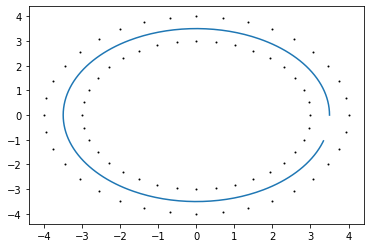

In [12]:
x = [a[0] for a in X]
y = [a[1] for a in X]
fig1 = plt.figure(1)
axes1 = fig1.subplots(1, 1)
axes1.plot([j[0] for j in r], [j[1] for j in r], 'o', color='black',ms=1);
axes1.plot(x, y,label='parametric curve')

In [22]:
#Формула компоненты вектора магнитной индукции
def b_func (x,j):
#    print(x);
    p = np.array([x[0], x[1]])
    q = np.array([x[2], x[3]])
    v = r[j] - p
    len = np.sqrt(v[0]**2+v[1]**2 +  h**2)
    coord_z = q[0]*v[1] - v[0]*q[1]
    res = mu0/(4*np.pi)*(coord_z)/len**3
    return res

In [23]:
def b(x):
    V = []
    for i in  range(L):
        V.append(b_func(x,i))
    return V

In [24]:
Y = []
for i in range(0,len(X)):
    Y.append(b(X[i]) + np.random.multivariate_normal(np.zeros((L)), G, 1)[0])

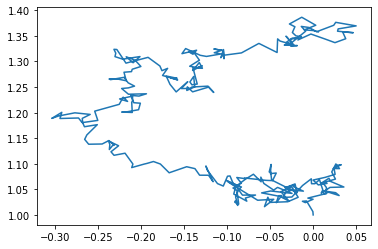

In [25]:
# График изменения вектора магнитной индукции
x = [a[2] for a in X]
y = [a[3] for a in X]

fig2 = plt.figure(1)
axes1 = fig2.subplots(1, 1)
axes1.plot(x, y,label='parametric curve')
      

In [26]:
mans = []
Pans = []
mans.append([my_r,0.0,0.0,1.0])
Pans.append([[1.0,0.0,0.0,0.0],[0.0,1.0,0.0,0.0],[0.0,0.0,1.0,0.0],[0.0,0.0,0.0,1.0]])
w  = np.array([1/N] * N)
u  = np.array([[my_r,0.0] for i in range(N)])
m_ = np.array([[my_r,0.0] for i in range(N)])
p_ = np.array([[[1.0,0.0],[0.0,1.0]] for i in range(N)])
m  = np.array([[my_r,0.0] for i in range(N)])
p  = np.array([[[1.0,0.0],[0.0,1.0]] for i in range(N)])
A  = np.array([[1.0,0.0],[0.0,1.0]])
Qp = np.array([[lmbda**2,0],[0,lmbda**2]])
Qq = np.array([[delta**2,0],[0,delta**2]])
H = np.array([[0.0,0.0] for i in range(L)])
R = np.array([[0.0] * ( L)  for i in range(L)])
for i in range(L):
    R[i][i] = 0.001
for i in range(len(Y)):
    # Прогноз
    t = [0.0,0.0,0.0,0.0]
    for j in range(N):
        m_[j] = A.dot(m[j])
        p_[j] = A.dot(p[j].dot(A.transpose())) + Qq
    # Генерация частиц
        u[j] +=  np.random.multivariate_normal(np.zeros((2)), Qp, 1)[0]
    # Построение матрицы H:
        for k in range(L):
            z = r[k] - u[j]
            lenn = math.sqrt(z[0]**2 + z[1]**2 +  h**2)
            z = z / (lenn**3) * mu0 / (4*math.pi)
            H[k] = np.array([z[1],-z[0]])
    #Построение матрицы S
        S = H.dot(p_[j].dot(H.transpose())) + R
     # Рассчитывание веса частиц
        var = multivariate_normal(mean= H.dot(m_[j]), cov = S)
        w[j] = var.pdf(Y[i])
    #Коррекция
        K = p_[j].dot(H.transpose().dot(np.linalg.inv(S)))
        v = np.array(Y[i]) - np.array(H.dot(m_[j]))
        v = np.dot(K , v.transpose())
        v = v.tolist();
        m[j] = m_[j] + v
        p[j] =  p_[j]   - np.dot(np.dot(K ,S),K.transpose())
    # Нормировка
    s = sum(w)
    w /= s 
    for j in range(N):
        t[0] += w[j] * u[j][0]
        t[1] += w[j] * u[j][1]
        t[2] += w[j] * m[j][0]
        t[3] += w[j] * m[j][1]
    # ресемплинг
    p_samples = copy.deepcopy(p)
    m_samples = copy.deepcopy(m)
    u_samples = copy.deepcopy(u)
    w_indices = [i for i in range(len(w))]
    w_dist = stats.rv_discrete(values=(w_indices, w))
    for j in range(N):
        resample_index = w_dist.rvs()
        m[j] = m_samples[resample_index]
        p[j] = p_samples[resample_index]
        u[j] = u_samples[resample_index]
    mans.append(t)    
    

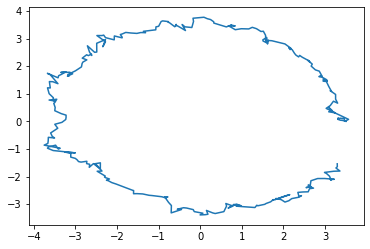

In [27]:
x = [a[0] for a in mans]
y = [a[1] for a in mans]
fig3 = plt.figure(1)
axes1 = fig3.subplots(1, 1)
axes1.plot(x, y,label='parametric curve')

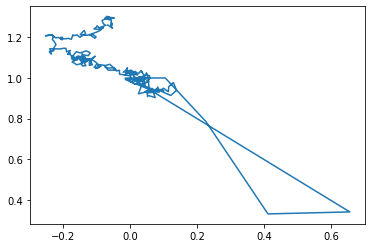

In [28]:
x = [a[2] for a in mans]
y = [a[3] for a in mans]
fig4 = plt.figure(1)
axes1 = fig4.subplots(1, 1)
axes1.plot(x, y,label='parametric curve')